<a href="https://colab.research.google.com/github/Taketo-Muroya/Nowcasting-Project/blob/main/nowcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The nowcasting of economic conditions in Japan using ML

## Setting Up

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/MyDrive/Colab Notebooks/Economic-Nowcasting-in-Japan')

Mounted at /content/drive


In [3]:
pip install pytrends

In [4]:
# Import packages
import re
import os
import sys
import requests
#import MeCab
#import oseti
#import urllib
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

from math import sqrt
from bs4 import BeautifulSoup
from pathlib import Path
from subprocess import call
from keras.regularizers import l2
from statsmodels.tsa.seasonal import seasonal_decompose

from nltk.corpus import stopwords as sw       
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    # add current dataset
    indices = range(i-history_size, i+1, step)
    temp = pd.DataFrame(dataset[indices])
    # replace current target to previous one
    temp.iat[history_size, 0] = temp.iat[history_size-1, 0]
    data.append(np.array(temp))

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [6]:
def model_eval_metrics(y_true, y_pred, classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

## Target variable: Indexes of Business Conditions (IBC)

The Index of Business Conditions (IBC) represents monthly economic conditions in Japan. This study uses either coincident index (level) or coincident ann (change from the previouse year: Year-over-Year) as a target variable.

In [7]:
ibc = pd.read_csv('data/ibc_new.csv')
ibc['Coincident ann'] = 100*ibc['Coincident Index'].pct_change(12)
ibc

,time,Coincident Index,Coincident ann
0,Jan-85,79.1,NaN
1,Feb-85,78.8,NaN
2,Mar-85,78.7,NaN
3,Apr-85,79.6,NaN
4,May-85,79.5,NaN
...,...,...,...
438,Jul-21,94.0,16.480793
439,Aug-21,91.0,10.840438
440,Sep-21,88.7,4.722550
441,Oct-21,89.8,1.468927


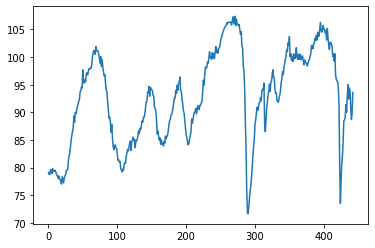

In [8]:
plt.plot(ibc['Coincident Index'])

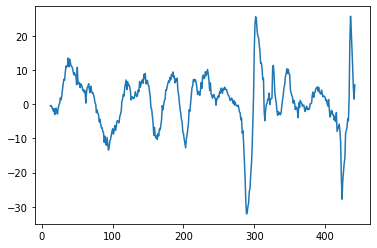

In [9]:
plt.plot(ibc['Coincident ann'])

## Electricity usage

Use electricity usage as predictors. The data up to 2016 is available on the Federation of Electric Power Companies (FEPC). For the data after 2016, it is needed to extract the data from 10 regional companies' websites. 

### Electricity usage data up to 2016 (FEPC)

In [9]:
past = pd.read_csv("data/electricity/past_elec.csv", index_col=0, parse_dates=True)
past

,total,manufac,home,hokkaido,touhoku,tokyo,cyubu,hokuriku,kansai,cyugoku,shikoku,kyushu,okinawa
date,,,,,,,,,,,,,
1989-01-01,51644033,17795609,33848424,1262917,2877745,11678950,4653448,1037449,5961367,2097258,1070222,2961908,247160
1989-02-01,47947215,17531314,30415901,1311784,2528461,10293537,4113099,914883,5350461,1916335,1056805,2686789,243747
1989-03-01,48573850,19163583,29410267,1188310,2731645,9722251,3966344,894781,5199840,1826465,989702,2669432,221497
1989-04-01,48788188,18542427,30245761,1201758,2554842,10350207,4164558,891169,5415203,1941870,957782,2522739,245633
1989-05-01,46276002,18451992,27824010,1105686,2488594,9452232,3689625,841579,4867001,1689974,901074,2522991,265254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-01,60716671,20925883,39790788,1957471,3770970,12635365,5267052,1221189,6348491,2538923,1325099,4171917,554311
2015-12-01,63604246,20599296,43004950,2037416,4337510,14039592,5478028,1451686,6592122,2808292,1457393,4308727,494184
2016-01-01,73205156,20441436,52763720,2629883,5181720,16404146,6879849,1822099,8437918,3423528,1842317,5631231,511029


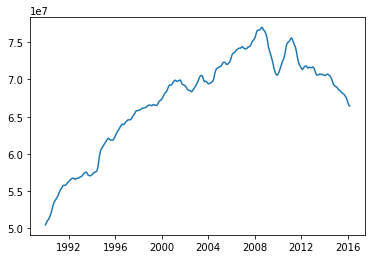

In [10]:
# Extract trend factor (Total)
sea = seasonal_decompose(past.iloc[:,0], two_sided=False, extrapolate_trend=0)
tt1 = sea.trend
plt.plot(tt1)

Correlation of level: 0.29
Correlation of YoY: 0.49


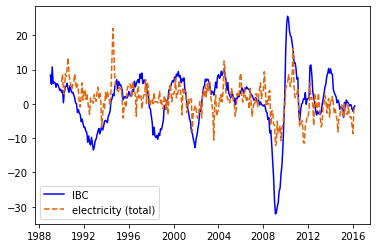

In [11]:
# Check correlation (Total)
level = ibc['Coincident Index'][48:375]
level.index = tt1.index
cor = level.corr(tt1)
print("Correlation of level: {:.2f}".format(cor))

aa1 = 100*past.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][48:375]
ann.index = aa1.index
cor = ann.corr(aa1)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(aa1.index, ibc['Coincident ann'][48:375], linestyle='-', color='b', label='IBC')
ax.plot(aa1.index, aa1, linestyle='--', color='#e46409', label='electricity (total)')
ax.legend(loc='best')
plt.savefig("images/total.png")

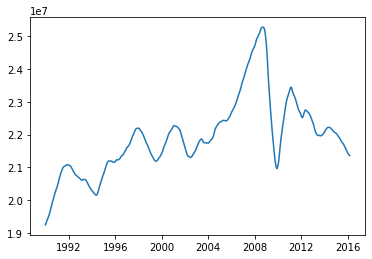

In [12]:
# Extract trend factor (Manufacture)
sea = seasonal_decompose(past.iloc[:,1], two_sided=False, extrapolate_trend=0)
tt2 = sea.trend
plt.plot(tt2)

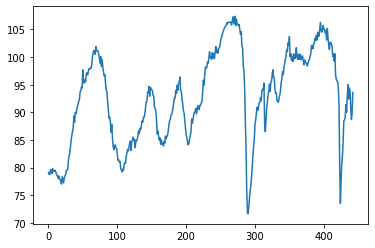

In [13]:
plt.plot(ibc['Coincident Index'])

Correlation of level: 0.38
Correlation of YoY: 0.84


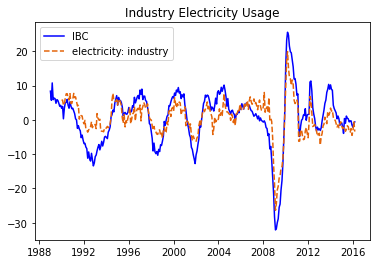

In [14]:
# Check correlation (Manufacture)
level = ibc['Coincident Index'][48:375]
level.index = tt2.index
cor = level.corr(tt2)
print("Correlation of level: {:.2f}".format(cor))

aa2 = 100*past.iloc[:,1].pct_change(12)
ann = ibc['Coincident ann'][48:375]
ann.index = aa2.index
cor = ann.corr(aa2)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(aa2.index, ibc['Coincident ann'][48:375], linestyle='-', color='b', label='IBC')
ax.plot(aa2.index, aa2, linestyle='--', color='#e46409', label='electricity: industry')
ax.legend(loc='best')
plt.title('Industry Electricity Usage')
plt.savefig("images/manufacture2016.png")

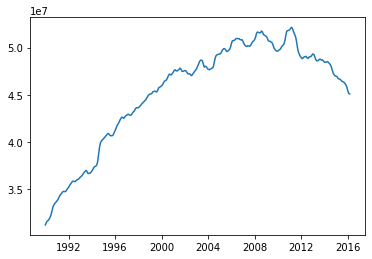

In [15]:
# Extract trend factor (Household)
sea = seasonal_decompose(past.iloc[:,2], two_sided=False, extrapolate_trend=0)
tt3 = sea.trend
plt.plot(tt3)

Correlation of level: 0.26
Correlation of YoY: 0.21


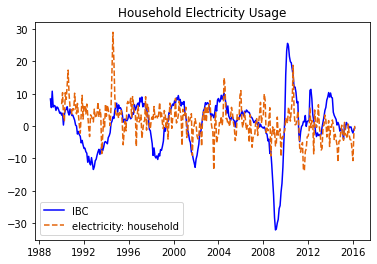

In [16]:
# Check correlation (Household)
level = ibc['Coincident Index'][48:375]
level.index = tt3.index
cor = level.corr(tt3)
print("Correlation of level: {:.2f}".format(cor))

aa3 = 100*past.iloc[:,2].pct_change(12)
ann = ibc['Coincident ann'][48:375]
ann.index = aa3.index
cor = ann.corr(aa3)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(aa3.index, ibc['Coincident ann'][48:375], linestyle='-', color='b', label='IBC')
ax.plot(aa3.index, aa3, linestyle='--', color='#e46409', label='electricity: household')
ax.legend(loc='best')
plt.title('Household Electricity Usage')
plt.savefig("images/home2016.png")

### Time series analysis

In [17]:
# Set time series dataset
X = pd.concat([tt2, tt3, aa2, aa3], axis=1)[12:]
y = ibc[60:375]
y = y.set_index('time')
X.index = y.index
ts = pd.concat([y, X], axis=1)
ts.to_csv("ts.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
ts = pd.read_csv('ts.csv', index_col=0, date_parser=dateparse, dtype='float')

# Split data into training and test set 
sp = round(0.8*len(ts))
train = ts[0:sp]
test = ts[sp:]

ts.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,Coincident Index,Coincident ann,manufac,home,manufac.1,home.1
time,,,,,,
2015-11-01,99.4,-0.300903,2.155927e+07,4.606606e+07,-2.555059,-4.382219
2015-12-01,98.6,-1.498501,2.149576e+07,4.585261e+07,-4.521196,-7.125220
2016-01-01,99.5,-2.163225,2.142728e+07,4.545227e+07,-3.165219,-10.679996
2016-02-01,99.0,-1.000000,2.139429e+07,4.514070e+07,-0.606093,-2.172183
2016-03-01,99.0,-0.602410,2.135816e+07,4.509313e+07,-3.410622,0.055157


In [18]:
# Unit root test of y (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['Coincident Index'])
print("Unit root test (y): {:.2f}".format(adf_result[1])) # p-value

# Take difference of y
diff = ts['Coincident Index'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_y): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['manufac'])
print("Unit root test (X): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['manufac'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_X): {:.2f}".format(adf_result[1])) # p-value

# Cointegration test (H0: non-cointegration)
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['manufac'])
print("Cointegration test (manufac): {:.2f}".format(coint_result[1])) # p-value
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['home'])
print("Cointegration test (home): {:.2f}".format(coint_result[1])) # p-value

Unit root test (y): 0.03
Unit root test (diff_y): 0.00
Unit root test (X): 0.36
Unit root test (diff_X): 0.00
Cointegration test (manufac): 0.04
Cointegration test (home): 0.05


### ARIMA Prediction

In [19]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident Index'], train.iloc[:,2:4], order=(1,1,1), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:       Coincident Index   No. Observations:                  252
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -377.330
Date:                Thu, 13 Jan 2022   AIC                            764.660
Time:                        01:43:23   BIC                            782.287
Sample:                    01-01-1990   HQIC                           771.753
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
manufac     1.822e-06    1.5e-06      1.218      0.223   -1.11e-06    4.76e-06
home       -9.799e-07   6.15e-07     -1.594      0.111   -2.18e-06    2.25e-07
ar.L1          0.8044      0.094      8.527      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test set score: 0.25


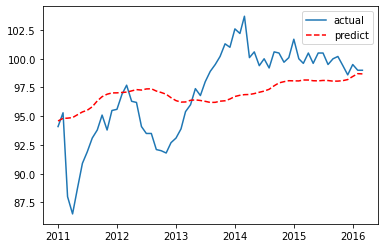

In [20]:
pred = SARIMAX.predict('2011-01-01', '2016-03-01', exog=test.iloc[:,2:4])
plt.plot(test['Coincident Index'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident Index'], pred)))

### ARIMA Prediction (YoY)

In [21]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident ann'], train.iloc[:,4:], order=(1,0,1), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:         Coincident ann   No. Observations:                  252
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -476.724
Date:                Thu, 13 Jan 2022   AIC                            963.448
Time:                        01:43:24   BIC                            981.095
Sample:                    01-01-1990   HQIC                           970.549
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
manufac.1      0.6108      0.042     14.477      0.000       0.528       0.693
home.1        -0.0193      0.025     -0.780      0.436      -0.068       0.029
ar.L1          0.9630      0.016     58.701      0.0

Test set score: 0.43


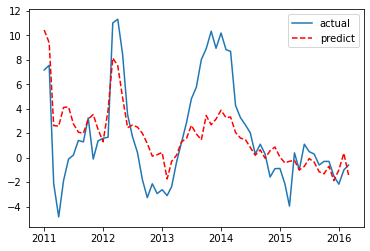

In [22]:
pred = SARIMAX.predict('2011-01-01', '2016-03-01', exog=test.iloc[:,4:])
plt.plot(test['Coincident ann'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident ann'], pred)))

### Random Forest

Training set score: 0.99
Cross-Validation score: 0.76
Test set score: 0.62


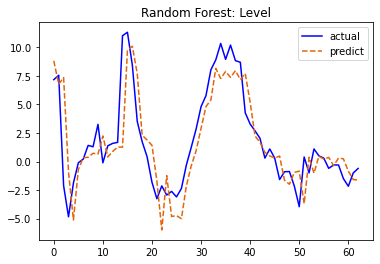

In [23]:
# Set X and y variables
X = ts.iloc[:,4:6]
y = ts['Coincident ann']

# Preprocess for adding AR
X_l = X.drop(X.index[0])
#X_l = X_l.drop(X_l.index[0])
X_l.reset_index(inplace=True, drop=True)

# Generate AR variable
y_l = y.drop(y.index[-1])
#y_l = y_l.drop(y_l.index[-1])
y_l.reset_index(inplace=True, drop=True)

# Add AR into X
X_t = pd.concat([y_l, X_l], axis=1)
y_t = y.drop(y.index[0])
#y_t = y_t.drop(y_t.index[0])
X_t.index = y_t.index

# Split data into training and test set 
sp = round(0.8*len(X_t))
X_train = X_t[0:sp]
X_test = X_t[sp:]
y_train = y_t[0:sp]
y_test = y_t[sp:]

# Fit the model
tm = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
#tm.feature_importances_

# Goodness of Fit
print("Training set score: {:.2f}".format(tm.score(X_train, y_train)))
print("Cross-Validation score: {:.2f}".format(
          np.mean(cross_val_score(tm, X_train, y_train, cv=5))))
print("Test set score: {:.2f}".format(tm.score(X_test, y_test)))

# Calculate the prediction
prediction = pd.DataFrame(tm.predict(X_test))
pre = prediction.values.tolist()
act = y_test.values.tolist()
predict = pd.DataFrame(pre, columns=['predict'])
actual = pd.DataFrame(act, columns=['actual'])
com = pd.concat([predict, actual], axis=1)

# Plot the prediction
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(com.index, com.actual, linestyle='-', color='b', label='actual')
ax.plot(com.index, com.predict, linestyle='--', color='#e46409', label='predict')
ax.legend(loc='best')
ax.set_title('Random Forest: Level')
plt.savefig("images/elect_rf.png")

### RNN-LSTM

In [24]:
features = pd.concat([ts['Coincident ann'], ts.iloc[:,4:6]], axis=1)
features.tail()

,Coincident ann,manufac.1,home.1
time,,,
2015-11-01,-0.300903,-2.555059,-4.382219
2015-12-01,-1.498501,-4.521196,-7.125220
2016-01-01,-2.163225,-3.165219,-10.679996
2016-02-01,-1.000000,-0.606093,-2.172183
2016-03-01,-0.602410,-3.410622,0.055157


In [25]:
# set training percentage
TRAIN_SPLIT = round(0.8*len(ts))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

252


In [26]:
# create the training and test data

past_history = 1
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, 
                                               past_history, future_target, STEP, single_step=True)

In [27]:
pd.DataFrame(dataset).head(7)

,0,1,2
0,0.364893,0.803268,0.842317
1,0.425707,0.814008,1.565246
2,0.016474,0.555977,0.187888
3,0.373965,0.598324,-0.181781
4,0.539800,0.930706,1.566351
5,0.560515,1.132483,1.145469
6,0.657838,1.137871,2.075868


In [28]:
pd.DataFrame(x_train_single[0])

,0,1,2
0,0.364893,0.803268,0.842317
1,0.364893,0.814008,1.565246


In [29]:
y_train_single[0]

0.42570703065737403

In [30]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [31]:
# construct the model

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(4, input_shape=x_train_single.shape[-2:])) #return_sequences=True 
#single_step_model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#single_step_model.add(tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2))
#single_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [32]:
# train the model
single_step_history = single_step_model.fit(train_data_single, epochs=10, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 7ms/step - loss: 0.7023 - val_loss: 0.3178
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4788 - val_loss: 0.2136
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2973 - val_loss: 0.2416
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2383 - val_loss: 0.2020
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2199 - val_loss: 0.1906
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2066 - val_loss: 0.1848
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1953 - val_loss: 0.1797
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1849 - val_loss: 0.1759
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1749 - val_loss: 0.1722
Epoch 10/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1652 - val_loss: 0.1689

In [33]:
# evaluate the model
model_eval_metrics(y_val_single, single_step_model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.050109,0.22385,0.168908,0.769498


Test set score: 0.77


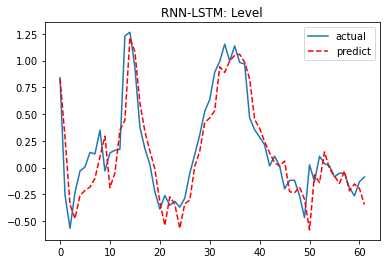

In [34]:
# visualize the result

plt.plot(y_val_single, label="actual")
plt.plot(single_step_model.predict(x_val_single), "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: Level')
plt.savefig("images/elect_lstm.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, single_step_model.predict(x_val_single))))

### Electricity usage data after 2016 (10 regional electricity companies)

In [35]:
all = pd.read_csv("data/electricity/all_elec_new.csv", index_col=0, parse_dates=True)
all.tail()

,total,manufac,home,hokkaido,touhoku,tokyo,cyubu,hokuriku,kansai,cyugoku,shikoku,kyushu,okinawa,dentou,ratioh,non-den,ratiom
date,,,,,,,,,,,,,,,,,
2019-10-01,56509007,20141679,36367328,2310263,6105910,21895980,10456171,2192666,11066220,4674528.0,2136900,6571589,720739,15632942,2.229369,40876065,0.492750
2019-11-01,53812805,18735168,35077637,2588457,6538410,21961360,10278030,2286570,10772939,4746639.0,2101400,6368962,600980,16117056,2.066332,37695749,0.497010
2019-12-01,57378162,18488889,38889273,3070698,7537130,25566860,11456472,2594920,12440043,5499171.0,2400560,7467543,587096,19012914,1.965872,38365248,0.481918
2020-01-01,64924636,17939473,46985163,3138465,7760140,26228480,11746264,2653126,12649978,5519369.0,2429270,7609594,574988,25528761,1.775577,39395875,0.455364
2020-02-01,62695206,17952203,44743003,2945058,7388070,23946550,11484744,2619241,12281023,5282637.0,2333920,7140795,547466,22533592,1.874486,40161614,0.446999


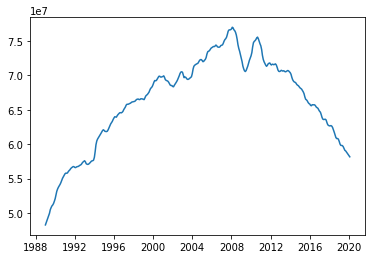

In [36]:
# Extract trend factor (Total)
sea = seasonal_decompose(all.iloc[:,0], extrapolate_trend='freq')
ttt1 = sea.trend
plt.plot(ttt1)

In [37]:
# Check correlation (Total)
level = ibc['Coincident Index'][48:]
level.index = ttt1.index
cor = level.corr(ttt1)
print("Correlation of level: {:.2f}".format(cor))

aaa1 = 100*all.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][48:]
ann.index = aaa1.index
cor = ann.corr(aaa1)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(aaa1.index, ibc['Coincident ann'][48:], linestyle='-', color='b', label='IBC')
ax.plot(aaa1.index, aaa1, linestyle='--', color='#e46409', label='electricity (total)')
ax.legend(loc='best')

ValueError: ignored

In [ ]:
# Extract trend factor (Manufacture)
sea = seasonal_decompose(all.iloc[:,1], extrapolate_trend='freq')
ttt2 = sea.trend
plt.plot(ttt2)

In [ ]:
# Check correlation (Manufacture)
level = ibc['Coincident Index'][48:]
level.index = ttt2.index
cor = level.corr(ttt2)
print("Correlation of level: {:.2f}".format(cor))

aaa2 = 100*all.iloc[:,1].pct_change(12)
ann = ibc['Coincident ann'][48:]
ann.index = aaa2.index
cor = ann.corr(aaa2)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(aaa2.index, ibc['Coincident ann'][48:], linestyle='-', color='b', label='IBC')
ax.plot(aaa2.index, aaa2, linestyle='--', color='#e46409', label='electricity: Industry')
ax.legend(loc='best')
plt.title('Industry Electricity Usage')
plt.savefig("images/manufacture_all.png")

In [ ]:
# Extract trend factor (Household)
sea = seasonal_decompose(all.iloc[:,2], extrapolate_trend='freq')
ttt3 = sea.trend
plt.plot(ttt3)

In [ ]:
# Check correlation (Household)
level = ibc['Coincident Index'][48:]
level.index = ttt3.index
cor = level.corr(ttt3)
print("Correlation of level: {:.2f}".format(cor))

aaa3 = 100*all.iloc[:,2].pct_change(12)
ann = ibc['Coincident ann'][48:]
ann.index = aaa3.index
cor = ann.corr(aaa3)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(aaa3.index, ibc['Coincident ann'][48:], linestyle='-', color='b', label='IBC')
ax.plot(aaa3.index, aaa3, linestyle='--', color='#e46409', label='electricity: household')
ax.legend(loc='best')
plt.title('Household Electricity Usage')
plt.savefig("images/home_all.png")

### Time series analysis

In [ ]:
# Set time series dataset
X = pd.concat([ttt2, ttt3, aaa2, aaa3], axis=1)[12:]
y = ibc[60:]
y = y.set_index('time')
X.index = y.index
ts = pd.concat([y, X], axis=1)
ts.to_csv("ts.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
ts = pd.read_csv('ts.csv', index_col=0, date_parser=dateparse, dtype='float')

# Split data into training and test set 
sp = round(0.8*len(ts))
train = ts[0:sp]
test = ts[sp:]

ts.tail()

In [ ]:
# Unit root test of y (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['Coincident Index'])
print("Unit root test (y): {:.2f}".format(adf_result[1])) # p-value

# Take difference of y
diff = ts['Coincident Index'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_y): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['manufac'])
print("Unit root test (X): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['manufac'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_X): {:.2f}".format(adf_result[1])) # p-value

# Cointegration test (H0: non-cointegration)
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['manufac'])
print("Cointegration test (manufac): {:.2f}".format(coint_result[1])) # p-value
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['home'])
print("Cointegration test (home): {:.2f}".format(coint_result[1])) # p-value

### ARIMA Prediction

In [ ]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident Index'], train.iloc[:,2:4], order=(1,1,1), freq='MS').fit()
print(SARIMAX.summary())

In [ ]:
pred = SARIMAX.predict('2014-03-01', '2020-02-01', exog=test.iloc[:,2:4])
plt.plot(test['Coincident Index'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident Index'], pred)))

### ARIMA Prediction (YoY)

In [ ]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident ann'], train.iloc[:,4:6], order=(1,0,1), freq='MS').fit()
print(SARIMAX.summary())

In [ ]:
pred = SARIMAX.predict('2014-03-01', '2020-02-01', exog=test.iloc[:,4:6])
plt.plot(test['Coincident ann'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident ann'], pred)))

### Random Forest

In [ ]:
# Set X and y variables
X = ts.iloc[:,4:6]
y = ts['Coincident ann']

# Preprocess for adding AR
X_l = X.drop(X.index[0])
#X_l = X_l.drop(X_l.index[0])
X_l.reset_index(inplace=True, drop=True)

# Generate AR variable
y_l = y.drop(y.index[-1])
#y_l = y_l.drop(y_l.index[-1])
y_l.reset_index(inplace=True, drop=True)

# Add AR into X
X_t = pd.concat([y_l, X_l], axis=1)
y_t = y.drop(y.index[0])
#y_t = y_t.drop(y_t.index[0])
X_t.index = y_t.index

# Split data into training and test set 
sp = round(0.8*len(X_t))
X_train = X_t[0:sp]
X_test = X_t[sp:]
y_train = y_t[0:sp]
y_test = y_t[sp:]

# Fit the model
tm = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
#tm.feature_importances_

# Goodness of Fit
print("Training set score: {:.2f}".format(tm.score(X_train, y_train)))
print("Cross-Validation score: {:.2f}".format(
          np.mean(cross_val_score(tm, X_train, y_train, cv=5))))
print("Test set score: {:.2f}".format(tm.score(X_test, y_test)))

# Calculate the prediction
prediction = pd.DataFrame(tm.predict(X_test))
pre = prediction.values.tolist()
act = y_test.values.tolist()
predict = pd.DataFrame(pre, columns=['predict'])
actual = pd.DataFrame(act, columns=['actual'])
com = pd.concat([predict, actual], axis=1)

# Plot the prediction
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(com.index, com.actual, linestyle='-', color='b', label='actual')
ax.plot(com.index, com.predict, linestyle='--', color='#e46409', label='predict')
ax.legend(loc='best')
ax.set_title('Random Forest: Level')
plt.savefig("images/elec_all_rf.png")

### RNN-LSTM

In [ ]:
features = pd.concat([ts['Coincident ann'], ts.iloc[:,4:6]], axis=1)
features.tail()

In [ ]:
# set training percentage
TRAIN_SPLIT = round(0.8*len(ts))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [ ]:
# create the training and test data

past_history = 6
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, 
                                               past_history, future_target, STEP, single_step=True)

In [ ]:
pd.DataFrame(dataset).head(7)

In [ ]:
pd.DataFrame(x_train_single[0])

In [ ]:
y_train_single[0]

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
# construct the model

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(4, input_shape=x_train_single.shape[-2:])) #return_sequences=True
#single_step_model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#single_step_model.add(tf.keras.layers.LSTM(4, dropout=0.2, recurrent_dropout=0.2))
#single_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0005), loss='mae')

In [ ]:
# train the model
single_step_history = single_step_model.fit(train_data_single, epochs=10, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

In [ ]:
# evaluate the model
model_eval_metrics(y_val_single, single_step_model.predict(x_val_single), classification="FALSE")

In [ ]:
# visualize the result
plt.plot(y_val_single, label="actual")
plt.plot(single_step_model.predict(x_val_single), "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: Level')
plt.savefig("images/elect_all_lstm.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, single_step_model.predict(x_val_single))))

## Google Trend

Use google trend information as predictors

### Google Trend API

In [10]:
# Import packages
from pytrends.request import TrendReq
plt.rcParams['font.family'] = 'IPAexGothic'

# API Connection
pytrends = TrendReq(hl='ja-JP', tz=360)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


Correlation of level: -0.88
Correlation of YoY: -0.68


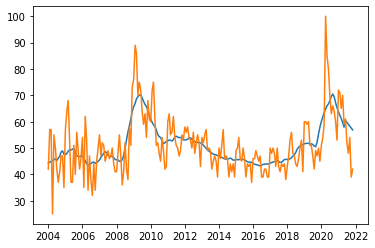

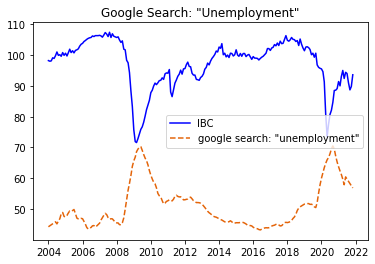

In [11]:
# Set keyword ("失業" = "unemployment")
kw_list = ["失業"]
pytrends.build_payload(kw_list, timeframe='2004-01-01 2021-11-30', geo='JP')
gt1 = pytrends.interest_over_time()
gt1 = gt1.rename(columns = {"失業": "unemployment", "isPartial": "info"})
gt1.to_csv("data/gt1.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
gt1 = pd.read_csv('data/gt1.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s1 = seasonal_decompose(gt1.iloc[:,0], extrapolate_trend='freq')
t1 = s1.trend
plt.plot(t1)
plt.plot(gt1.iloc[:,0])

# Check correlation
level = ibc['Coincident Index'][228:]
level.index = t1.index
cor = level.corr(t1)
print("Correlation of level: {:.2f}".format(cor))

a1 = gt1.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][228:]
ann.index = a1.index
cor = ann.corr(a1)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t1.index, ibc['Coincident Index'][228:], linestyle='-', color='b', label='IBC')
ax.plot(t1.index, t1, linestyle='--', color='#e46409', label='google search: "unemployment"')
ax.legend()
plt.title('Google Search: "Unemployment"')
plt.savefig("images/google1.png")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


Correlation of level: 0.32
Correlation of YoY: 0.13


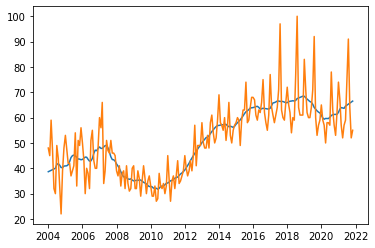

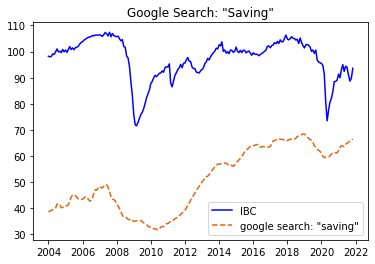

In [12]:
# Set keyword ("貯金" = "saving")
kw_list = ["貯金"]
pytrends.build_payload(kw_list, timeframe='2004-01-01 2021-11-30', geo='JP')
gt2 = pytrends.interest_over_time()
gt2 = gt2.rename(columns = {"貯金": "saving", "isPartial": "info"})
gt2.to_csv("data/gt2.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
gt2 = pd.read_csv('data/gt2.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s2 = seasonal_decompose(gt2.iloc[:,0], extrapolate_trend='freq')
t2 = s2.trend
plt.plot(t2)
plt.plot(gt2.iloc[:,0])

# Check correlation
level = ibc['Coincident Index'][228:]
level.index = t2.index
cor = level.corr(t2)
print("Correlation of level: {:.2f}".format(cor))

a2 = gt2.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][228:]
ann.index = a2.index
cor = ann.corr(a2)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t2.index, ibc['Coincident Index'][228:], linestyle='-', color='b', label='IBC')
ax.plot(t2.index, t2, linestyle='--', color='#e46409', label='google search: "saving"')
ax.legend()
plt.title('Google Search: "Saving"')
plt.savefig("images/google2.png")

In [13]:
# Combine google trend (level)
gtrend_l = pd.concat([t1, t2], axis=1)

# Combine google trend (YoY)
gtrend_y = pd.concat([a1, a2], axis=1)
#gtrend_y = gtrend_y.drop(gtrend_y.index[0:12])

### Time series analysis

In [14]:
# Set time series dataset
X = pd.concat([gtrend_l, gtrend_y], axis=1)
y = ibc[228:]
y = y.set_index('time')
X.index = y.index
ts = pd.concat([y, X], axis=1)
ts.to_csv("ts.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
ts = pd.read_csv('ts.csv', index_col=0, date_parser=dateparse, dtype='float')

# Split data into training and test set
sp = round(0.8*len(ts))
train = ts[0:sp]
test = ts[sp:]

ts.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,Coincident Index,Coincident ann,unemployment,saving,unemployment.1,saving.1
time,,,,,,
2021-07-01,94.0,16.480793,59.731983,64.920115,-0.257143,0.315789
2021-08-01,91.0,10.840438,59.016220,65.317988,-0.238095,0.166667
2021-09-01,88.7,4.722550,58.300456,65.715861,-0.181818,0.015873
2021-10-01,89.8,1.468927,57.584693,66.113733,-0.390625,-0.087719
2021-11-01,93.6,5.643341,56.868930,66.511606,-0.300000,0.037736


In [15]:
# Unit root test of y (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['Coincident Index'])
print("Unit root test (y): {:.2f}".format(adf_result[1])) # p-value

# Take difference of y
diff = ts['Coincident Index'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_y): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['unemployment'])
print("Unit root test (X): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['unemployment'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_X): {:.2f}".format(adf_result[1])) # p-value

# Cointegration test (H0: non-cointegration)
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['unemployment'])
print("Cointegration test (unemployment): {:.2f}".format(coint_result[1])) # p-value
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['saving'])
print("Cointegration test (saving): {:.2f}".format(coint_result[1])) # p-value

Unit root test (y): 0.07
Unit root test (diff_y): 0.00
Unit root test (X): 0.15
Unit root test (diff_X): 0.03
Cointegration test (unemployment): 0.19
Cointegration test (saving): 0.26


### ARIMA Prediction

In [17]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident Index'], train.iloc[:,2:3], order=(1,0,0), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:       Coincident Index   No. Observations:                  172
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -299.750
Date:                Thu, 13 Jan 2022   AIC                            605.500
Time:                        05:48:35   BIC                            614.943
Sample:                    01-01-2004   HQIC                           609.331
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
unemployment    -0.7552      0.094     -8.041      0.000      -0.939      -0.571
ar.L1            1.0000      0.001   1212.197      0.000       0.998       1.002
sigma2           1.8110      0.113     15.98

Test set score: 0.66


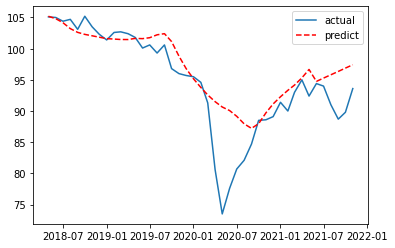

In [19]:
pred = SARIMAX.predict('2018-05-01', '2021-11-01', exog=test.iloc[:,2:3])
plt.plot(test['Coincident Index'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident Index'], pred)))

### Random Forest

Training set score: 0.99
Cross-Validation score: 0.77
Test set score: 0.80


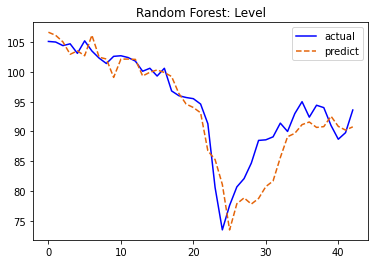

In [20]:
# Set X and y variables
X = ts.iloc[:,2:3]
y = ts['Coincident Index']

# Preprocess for adding AR
X_l = X.drop(X.index[0])
#X_l = X_l.drop(X_l.index[0])
X_l.reset_index(inplace=True, drop=True)

# Generate AR variable
y_l = y.drop(y.index[-1])
#y_l = y_l.drop(y_l.index[-1])
y_l.reset_index(inplace=True, drop=True)

# Add AR into X
X_t = pd.concat([y_l, X_l], axis=1)
y_t = y.drop(y.index[0])
#y_t = y_t.drop(y_t.index[0])
X_t.index = y_t.index

# Split data into training and test set 
sp = round(0.8*len(X_t))
X_train = X_t[0:sp]
X_test = X_t[sp:]
y_train = y_t[0:sp]
y_test = y_t[sp:]

# Fit the model
tm = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
#tm.feature_importances_

# Goodness of Fit
print("Training set score: {:.2f}".format(tm.score(X_train, y_train)))
print("Cross-Validation score: {:.2f}".format(
          np.mean(cross_val_score(tm, X_train, y_train, cv=5))))
print("Test set score: {:.2f}".format(tm.score(X_test, y_test)))

# Calculate the prediction
prediction = pd.DataFrame(tm.predict(X_test))
pre = prediction.values.tolist()
act = y_test.values.tolist()
predict = pd.DataFrame(pre, columns=['predict'])
actual = pd.DataFrame(act, columns=['actual'])
com = pd.concat([predict, actual], axis=1)

# Plot the prediction
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(com.index, com.actual, linestyle='-', color='b', label='actual')
ax.plot(com.index, com.predict, linestyle='--', color='#e46409', label='predict')
ax.legend(loc='best')
ax.set_title('Random Forest: Level')
plt.savefig("images/google_rf.png")

In [21]:
tm.feature_importances_

array([0.79556366, 0.20443634])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


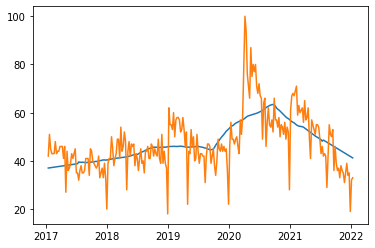

In [24]:
# Set keyword ("失業" = "unemployment")
kw_list = ["失業"]
pytrends.build_payload(kw_list, timeframe='today 5-y', geo='JP')
#pytrends.build_payload(kw_list, timeframe='2004-01-01 2020-02-29', geo='JP')
gt3 = pytrends.interest_over_time()
gt3 = gt3.rename(columns = {"失業": "unemployment", "isPartial": "info"})
gt3.to_csv("data/gt3.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
gt3 = pd.read_csv('data/gt3.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s3 = seasonal_decompose(gt3.iloc[:,0], extrapolate_trend='freq')
t3 = s3.trend

plt.plot(t3)
plt.plot(gt3.iloc[:,0])

In [31]:
gtw = pd.DataFrame(t3)
gtw.to_csv("data/gtw.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


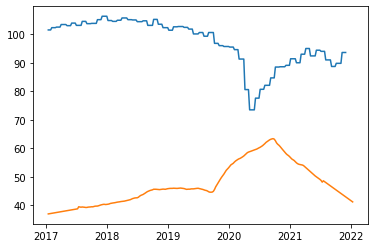

In [281]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
XX = pd.read_csv('data/gtw_ibc.csv', index_col=0, date_parser=dateparse, dtype='float')

plt.plot(XX)

In [282]:
XX = XX.dropna()
XX

,ibc,unemployment
date,,
2017-01-15,101.5,37.034999
2017-01-22,101.5,37.106183
2017-01-29,101.5,37.177367
2017-02-05,102.3,37.248552
2017-02-12,102.3,37.319736
...,...,...
2021-10-31,89.8,44.201839
2021-11-07,93.6,43.906232
2021-11-14,93.6,43.610624


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- ibc
Feature names seen at fit time, yet now missing:
- Coincident Index

  warnings.warn(message, FutureWarning)


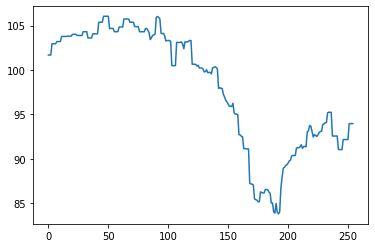

In [283]:
plt.plot(tm.predict(XX))

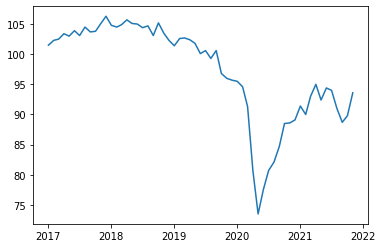

In [285]:
plt.plot(ts.iloc[156:,0:1])

### RNN-LSTM

In [262]:
# set the dataset
features = pd.concat([ts['Coincident Index'], ts.iloc[:,2:3]], axis=1)
features.tail()

,Coincident Index,unemployment
time,,
2021-07-01,94.0,59.731983
2021-08-01,91.0,59.016220
2021-09-01,88.7,58.300456
2021-10-01,89.8,57.584693
2021-11-01,93.6,56.868930


In [263]:
# set training percentage
TRAIN_SPLIT = round(0.8*len(features))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

172


In [264]:
# create the training and test data

past_history = 3
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

In [265]:
pd.DataFrame(dataset).head(7)

,0,1
0,0.032678,-0.834625
1,0.006228,-0.784105
2,0.019453,-0.733585
3,0.151705,-0.683064
4,0.125255,-0.632544
5,0.244281,-0.582024
6,0.402984,-0.687368


In [266]:
pd.DataFrame(x_train_single[0])

,0,1
0,0.032678,-0.834625
1,0.006228,-0.784105
2,0.019453,-0.733585
3,0.019453,-0.683064


In [267]:
y_train_single[0]

0.15170511389896058

In [268]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [269]:
# construct the model

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(8, input_shape=x_train_single.shape[-2:]))
#single_step_model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#single_step_model.add(tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#single_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4)))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss='mae')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [270]:
# train the model
single_step_history = single_step_model.fit(train_data_single, epochs=10, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 3s 6ms/step - loss: 0.9384 - val_loss: 1.1023
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.8192 - val_loss: 1.0174
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6996 - val_loss: 0.9410
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5811 - val_loss: 0.8722
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4819 - val_loss: 0.7950
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4024 - val_loss: 0.6946
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3346 - val_loss: 0.5815
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2786 - val_loss: 0.4801
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2463 - val_loss: 0.4079
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2303 - val_loss: 0.3663

In [271]:
# evaluate the model
model_eval_metrics(y_val_single, single_step_model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.335154,0.578925,0.366279,0.685128


Test set score: 0.69


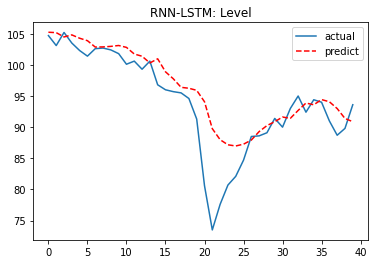

In [272]:
# visualize the result

plt.plot(y_val_single*data_std[0]+data_mean[0], label="actual")
plt.plot(single_step_model.predict(x_val_single)*data_std[0]+data_mean[0], "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: Level')
plt.savefig("images/google_lstm.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, single_step_model.predict(x_val_single))))

In [273]:
# load the weekly data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
XX = pd.read_csv('data/gtw_ibc.csv', index_col=0, date_parser=dateparse, dtype='float')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


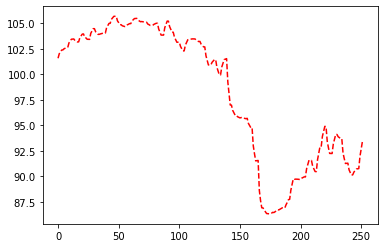

In [274]:
# feature scaling
dataset = XX.iloc[:255,:].values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

# create the test data
x_single, y_single = multivariate_data(dataset, dataset[:,0], 0, None, past_history, future_target, STEP, single_step=True)

# save the output
past_estimate = pd.DataFrame(single_step_model.predict(x_single)*data_std[0]+data_mean[0])
plt.plot(past_estimate, "r", linestyle='--', label="predict")

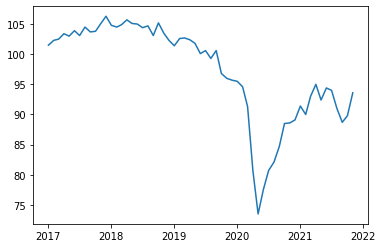

In [275]:
plt.plot(ts.iloc[156:,0:1])

In [276]:
# nowcast the future IBC
for i in range(255, 261):
  XX.iat[i,0] = float(single_step_model.predict(x_single)[-1]*data_std[0]+data_mean[0])
  #XX.iat[i,0] = XX.iat[i-1,0]
  temp = XX.iloc[:i+1,:]
  print(temp.tail())

  # feature scaling
  dataset = temp.values
  data_mean = dataset.mean(axis=0)
  data_std = dataset.std(axis=0)
  dataset = (dataset-data_mean)/data_std
  
  # create the test data
  x_single, y_single = multivariate_data(dataset, dataset[:,0], 0, None, past_history, future_target, STEP, single_step=True)

  XX.iat[i,0] = float(single_step_model.predict(x_single)[-1]*data_std[0]+data_mean[0])
  print(XX.tail(10))

# save the output
future_estimate = pd.DataFrame(XX.iloc[255:262,0])

                  ibc  unemployment
date                               
2021-11-07  93.600000     43.906232
2021-11-14  93.600000     43.610624
2021-11-21  93.600000     43.315017
2021-11-28  93.600000     43.019409
2021-12-05  93.403671     42.723801
                  ibc  unemployment
date                               
2021-11-07  93.600000     43.906232
2021-11-14  93.600000     43.610624
2021-11-21  93.600000     43.315017
2021-11-28  93.600000     43.019409
2021-12-05  93.410812     42.723801
2021-12-12        NaN     42.428194
2021-12-19        NaN     42.132586
2021-12-26        NaN     41.836978
2022-01-02        NaN     41.541371
2022-01-09        NaN     41.245763
                  ibc  unemployment
date                               
2021-11-14  93.600000     43.610624
2021-11-21  93.600000     43.315017
2021-11-28  93.600000     43.019409
2021-12-05  93.410812     42.723801
2021-12-12  93.410812     42.428194
                  ibc  unemployment
date                        

,ibc
date,
2021-12-05,93.410812
2021-12-12,93.331085
2021-12-19,93.261200
2021-12-26,93.181564
2022-01-02,93.122536
2022-01-09,93.072815


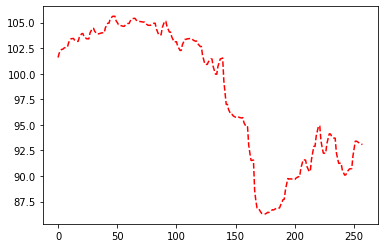

In [277]:
#plt.plot(XX.iloc[52:112,0], "r", linestyle='--', label="predict")
plt.plot(single_step_model.predict(x_single)*data_std[0]+data_mean[0], "r", linestyle='--', label="predict")

In [278]:
new = past_estimate.set_axis(['ibc'], axis='columns')
df_concat = pd.concat([new, future_estimate])
df_concat
#plt.plot(df_concat, "r", linestyle='--', label="predict")